In [25]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from scipy.stats import ttest_rel
from tqdm import tqdm

from philharmonic.utils import load_cluster_json, parse_GO_database

In [32]:
def vst(counts, alpha=1):
    """
    Apply a variance stabilizing transformation to count data.

    Parameters:
    counts (array-like): The input count data
    alpha (float): A small constant to avoid taking log of zero

    Returns:
    numpy.ndarray: The transformed data
    """
    counts = np.asarray(counts)
    return np.log2(counts + np.sqrt(counts + alpha**2))


def bicor_matrix(X, epsilon=1e-12):
    """
    Compute pairwise bi-weight mid-correlation for all genes.

    Parameters:
    X (np.ndarray): A 2D array of shape (n_genes, n_samples) containing normalized count data
    epsilon (float): Small value to avoid division by zero

    Returns:
    np.ndarray: A 2D array of shape (n_genes, n_genes) containing pairwise correlations
    """
    # Compute median and MAD for each gene
    gene_medians = np.median(X, axis=1)
    gene_mads = np.median(np.abs(X - gene_medians[:, np.newaxis]), axis=1)

    # Handle genes with zero MAD
    gene_mads = np.maximum(gene_mads, epsilon)

    # Compute U matrix
    U = (X - gene_medians[:, np.newaxis]) / (9 * gene_mads[:, np.newaxis])

    # Compute weights
    W = (1 - U**2) ** 2
    W[np.abs(U) >= 1] = 0

    # Compute weighted centered expression
    X_weighted = W * (X - gene_medians[:, np.newaxis])

    # Compute pairwise correlations
    norms = np.sqrt(np.sum(X_weighted**2, axis=1))
    norms = np.maximum(norms, epsilon)  # Avoid division by zero
    corr_matrix = np.dot(X_weighted, X_weighted.T) / np.outer(norms, norms)

    # Set diagonal to 1 and handle numerical instability
    np.fill_diagonal(corr_matrix, 1)
    corr_matrix = np.clip(corr_matrix, -1, 1)

    return corr_matrix

In [40]:
def extract_cluster_correlations(
    cluster_members, correlation_df, summary_func=None, dataframe=False
):
    """
    Extract the lower diagonal of pairwise correlations for a set of genes.

    Parameters:
    cluster_members (list): A list of gene names
    correlation_df (pd.DataFrame): A DataFrame containing pairwise correlations

    Returns:
    pd.DataFrame: A DataFrame containing pairwise correlations for the input genes
    """
    members = list(set(cluster_members).intersection(correlation_df.index))
    cluster_correlations = correlation_df.loc[members, members].values[
        np.tril_indices(len(members), k=-1)
    ]
    if summary_func:
        return summary_func(cluster_correlations)
    elif dataframe:
        return correlation_df.loc[members, members]
    else:
        return cluster_correlations


def resample_correlation_matrix(correlation_df, random_seed=42):
    """
    Randomly re-order the row and column names and reassign them to a correlation matrix.
    """
    from copy import deepcopy

    new_df = deepcopy(correlation_df)
    rng = np.random.default_rng(random_seed)
    new_prot_order = rng.permutation(new_df.index)
    new_df.index = new_prot_order
    new_df.columns = new_prot_order
    return new_df

In [48]:
# Initial files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/20240912-dmelaAll-phil_v0.2.0_clusters.functional.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/20240912-dmelaAll-phil_v0.2.0_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/20240912-dmelaAll-phil_v0.2.0_GO_map.csv"

GO_DB = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/go.obo"

# Gene Expression Data
data_root = Path(
    "/mnt/home/ssledzieski/database/philharmonic/d_melanogaster/immunity_timeseries/data"
)
metadata_path = data_root / "metadata_table.csv"
raw_count_path = data_root / "raw_counts.csv"
normalized_count_path = data_root / "normalized_counts.csv"
normalized_log_filt_path = data_root / "normalized_counts_log_filt.csv"
immune_genes_path = data_root / "List_of_immune_genes_updated.csv"
name_map_path = data_root / "fbgn_fbtr_fbpp_expanded_fb_2025_02.tsv.gz"

# Output paths
IMG_DIR = Path(
    "/mnt/home/ssledzieski/Projects/philharmonic-experiments/img/dmel_immune"
)
os.makedirs(IMG_DIR, exist_ok=True)

---

# Load Files

In [30]:
cluster_dict = load_cluster_json(cluster_file_path)
go_database = parse_GO_database(GO_DB)
full_G = nx.read_weighted_edgelist(network_file_path, delimiter="\t")

In [351]:
metadata = pd.read_csv(metadata_path, index_col=0).sort_values(by="hours")
expression_df = pd.read_csv(raw_count_path, index_col=0)
normalized_conts = pd.read_csv(normalized_count_path, index_col=0)
normalized_log_filt = pd.read_csv(normalized_log_filt_path, index_col=0)
immune_genes = pd.read_csv(immune_genes_path, index_col=3)

name_map = pd.read_csv(
    name_map_path, sep="\t", compression="gzip", skiprows=4, index_col=9
).dropna()

In [352]:
name_map

,## organism,gene_type,gene_ID,gene_symbol,gene_fullname,annotation_ID,transcript_type,transcript_ID,transcript_symbol,polypeptide_symbol
polypeptide_ID,,,,,,,,,,
FBpp0071677,Dmel,protein_coding_gene,FBgn0000008,a,arc,CG6741,mRNA,FBtr0071763,a-RA,a-PA
FBpp0071678,Dmel,protein_coding_gene,FBgn0000008,a,arc,CG6741,mRNA,FBtr0071764,a-RB,a-PB
FBpp0099961,Dmel,protein_coding_gene,FBgn0000008,a,arc,CG6741,mRNA,FBtr0100521,a-RC,a-PC
FBpp0309745,Dmel,protein_coding_gene,FBgn0000008,a,arc,CG6741,mRNA,FBtr0342981,a-RD,a-PD
FBpp0082828,Dmel,protein_coding_gene,FBgn0000014,abd-A,abdominal A,CG10325,mRNA,FBtr0083387,abd-A-RA,abd-A-PA
...,...,...,...,...,...,...,...,...,...,...
FBpp0311094,Dmel,protein_coding_gene,FBgn0290174,Nsf2,N-ethylmaleimide-sensitive factor 2,CG33101,mRNA,FBtr0344766,Nsf2-RB,Nsf2-PB
FBpp0311095,Dmel,protein_coding_gene,FBgn0290174,Nsf2,N-ethylmaleimide-sensitive factor 2,CG33101,mRNA,FBtr0344767,Nsf2-RC,Nsf2-PC
FBpp0302536,Dmel,protein_coding_gene,FBgn0290182,Su(var)3-9,Suppressor of variegation 3-9,CG43664,mRNA,FBtr0310385,Su(var)3-9-RA,Su(var)3-9-PA


In [353]:
def map_name(pp):
    pp_id = pp.split(".")[1]
    if pp_id in name_map.index:
        return name_map.loc[pp_id, "gene_ID"]
    else:
        return pp_id

In [354]:
dense_df = expression_df[
    np.sum(expression_df > 0, axis=1) > expression_df.shape[1] * 0.5
]
vst_df = pd.DataFrame(
    vst(dense_df.values), index=dense_df.index, columns=dense_df.columns
)
dense_corr = bicor_matrix(vst(dense_df.values))
dense_corr_df = pd.DataFrame(dense_corr, index=dense_df.index, columns=dense_df.index)

logger.info(f"Expression data has shape: {expression_df.shape}")
logger.info(f"Dense correlation matrix has shape: {dense_corr_df.shape}")
logger.info(f"Dense correlation matrix has {np.sum(np.isnan(dense_corr))} NaN values")

2025-05-19 16:10:03.615 | INFO     | __main__:<module>:6 - Expression data has shape: (17736, 41)
2025-05-19 16:10:03.617 | INFO     | __main__:<module>:7 - Dense correlation matrix has shape: (15568, 15568)
2025-05-19 16:10:03.933 | INFO     | __main__:<module>:8 - Dense correlation matrix has 0 NaN values


In [355]:
cluster_proteins = set(
    [
        map_name(i)
        for i in set.union(*[set(i["members"]) for i in cluster_dict.values()])
    ]
)
removed_proteins = set(expression_df.index).difference(dense_corr_df.index)
removed_cluster_proteins = cluster_proteins.intersection(removed_proteins)
logger.info(
    f"Removed {len(removed_proteins)} proteins from the expression data because of sparsity, {len(removed_cluster_proteins)} which were in clusters."
)

2025-05-19 16:10:03.991 | INFO     | __main__:<module>:4 - Removed 2168 proteins from the expression data because of sparsity, 94 which were in clusters.


In [356]:
rand_correlation_df = resample_correlation_matrix(dense_corr_df)

cluster_corr_df = pd.DataFrame(
    {
        "key": cluster_dict.keys(),
        "True": [
            extract_cluster_correlations(
                [
                    map_name(n)
                    for n in c["members"] + list(c["recipe"]["degree"]["0.75"])
                ],
                dense_corr_df,
                np.median,
            )
            for c in tqdm(cluster_dict.values(), total=len(cluster_dict))
        ],
        "Randomized": [
            extract_cluster_correlations(
                [
                    map_name(n)
                    for n in c["members"] + list(c["recipe"]["degree"]["0.75"])
                ],
                rand_correlation_df,
                np.median,
            )
            for c in tqdm(cluster_dict.values(), total=len(cluster_dict))
        ],
    }
).dropna()

 69%|██████▉   | 197/285 [00:01<00:00, 214.91it/s]/home/ssledzieski/miniforge3/envs/phil/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ssledzieski/miniforge3/envs/phil/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 93%|█████████▎| 265/285 [00:01<00:00, 277.61it/s]/home/ssledzieski/miniforge3/envs/phil/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ssledzieski/miniforge3/envs/phil/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ssledzieski/miniforge3/envs/phil/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice

In [357]:
cluster_corr_df

,key,True,Randomized
0,747394121115208532,0.630303,0.525933
1,1614852247292496341,0.484855,0.598888
2,402506198413014357,0.560482,0.517042
3,910498388155438464,0.660933,0.598665
4,1015360824453328460,0.705268,0.609052
...,...,...,...
279,1374014175364234128,0.592223,0.716510
280,1518793671124742251,0.574659,0.866954
281,1204866372965546476,0.799907,0.824804
282,2086022063353386055,0.745264,0.608944


/tmp/ipykernel_3178157/3921298193.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


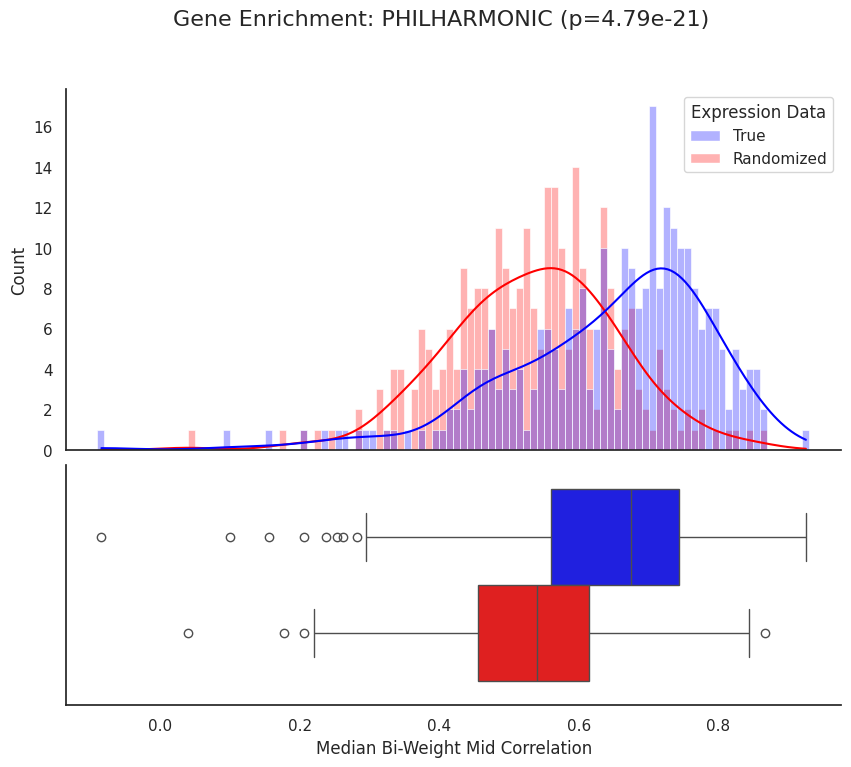

In [401]:
sns.set_palette("colorblind")
sns.set_theme(style="white", palette="pastel", font_scale=1)

tstat_rand, p_rand = ttest_rel(
    cluster_corr_df["True"], cluster_corr_df["Randomized"], alternative="greater"
)

plot_df = cluster_corr_df.melt("key").rename(
    {"value": "Median Bi-Weight Mid Correlation", "variable": "Expression Data"}, axis=1
)

# Create figure and gridspec
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 2], hspace=0.05)

# Create top subplot for histogram
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

sns.histplot(
    data=plot_df,
    x="Median Bi-Weight Mid Correlation",
    hue="Expression Data",
    alpha=0.3,
    kde=True,
    bins=np.arange(-0.1, 1.05, 0.01),
    palette=["blue", "red"],
    common_norm=False,
    ec="white",
    ax=ax0,
)

sns.boxplot(
    data=cluster_corr_df.melt("key"),
    x="value",
    hue="variable",
    palette=["blue", "red"],
    ax=ax1,
)

ax0.set_xlabel("")  # Remove x-label from top plot
ax1.set_xlabel("Median Bi-Weight Mid Correlation")  # Add x-label to bottom plot
ax0.set_xticklabels([])  # Remove x-ticks from top plot


ax0.set_xlim(ax1.get_xlim())  # Align the x-axis of both subplots
ax1.get_legend().remove()  # Remove legend from bottom plot

plt.suptitle(f"Gene Enrichment: PHILHARMONIC (p={p_rand:.3})", fontsize=16)

# Show the plot
sns.despine()
plt.tight_layout()
plt.savefig(IMG_DIR / "dmela_immune_randomization_comparison.svg")
plt.show()

1346451422620795471


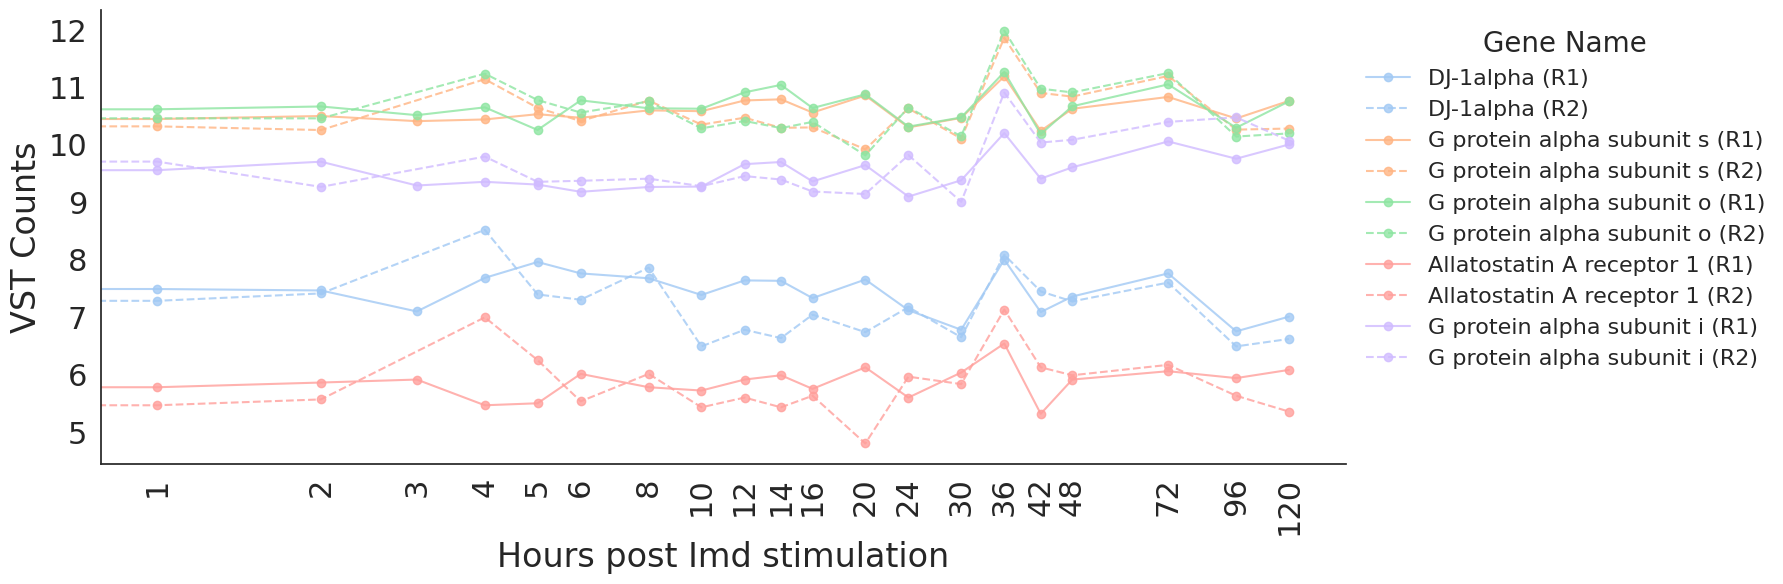

In [ ]:
for i, (ck, clus) in enumerate(cluster_dict.items()):
    # if i == 100:
    if "7227.FBpp0070550" in clus["members"]:
        print(ck)
        gn_names = []
        for j in clus["members"]:
            j = j.split(".")[1]
            try:
                gn_n = name_map.loc[j, "gene_ID"]
                if gn_n in vst_df.index:
                    gn_names.append(gn_n)
                else:
                    print(f"Gene {j} not in VST data")
                    continue
            except KeyError:
                continue
        bridge_counts = vst_df.loc[gn_names]
        break

name_map_subset = name_map[
    name_map.index.isin([i.split(".")[1] for i in clus["members"]])
][["gene_ID", "gene_fullname"]]
name_map_k = name_map_subset["gene_ID"].values
name_map_v = name_map_subset["gene_fullname"].values
name_map_dict = {k: v for k, v in zip(name_map_k, name_map_v)}

bridge_counts.rename(
    name_map_dict,
    inplace=True,
)
# bridge_counts.head()

fig, ax = plt.subplots(figsize=(18, 6))

A_meta = metadata[metadata["sample_ID"].str.contains("A")]
B_meta = metadata[metadata["sample_ID"].str.contains("B")]

for _, row in bridge_counts.iterrows():
    rep_A = np.array([j for (i, j) in zip(row.index, row.values) if "A" in i])
    rep_B = np.array([j for (i, j) in zip(row.index, row.values) if "B" in i])
    plt.plot(
        A_meta["hours"].astype(float),
        rep_A,
        label=f"{row.name} (R1)",
        alpha=0.8,
        marker="o",
    )
    # get color used for last plot
    color = plt.gca().lines[-1].get_color()
    plt.plot(
        B_meta["hours"].astype(float),
        rep_B,
        label=f"{row.name} (R2)",
        linestyle="--",
        color=color,
        alpha=0.8,
        marker="o",
    )

# use a log x scale, but actually show every tick
nonzero_hours = [i for i in A_meta["hours"].astype(float) if i > 0]
ax.set_xscale("log")

# Set ticks at each hour value
ax.set_xticks(nonzero_hours)

# Format tick labels to show exact values (no decimals for integers)
tick_labels = [f"{int(h)}" if h.is_integer() else f"{h}" for h in nonzero_hours]
ax.set_xticklabels(tick_labels, rotation=90)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Hours post Imd stimulation", fontsize=24)
plt.ylabel("VST Counts", fontsize=24)
# move legend outside of plot
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    fontsize=16,
    title="Gene Name",
    title_fontsize=20,
    frameon=False,
)
sns.despine()
plt.tight_layout()
plt.savefig(IMG_DIR / "dmela_immune_bridge_time_series.svg")

In [383]:
B_meta["hours"].astype(float).values  # use a log x scale, but actually show every tick

array([  0.,   1.,   2.,   4.,   5.,   6.,   8.,  10.,  12.,  14.,  16.,
        20.,  24.,  30.,  36.,  42.,  48.,  72.,  96., 120.])